In [7]:
import sys
sys.path.append('../_amigocloud')
import simplekml
from amigocloud import AmigoCloud
import pandas as pd
from shapely import wkb
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint
import os

In [8]:
def get_unidad_local():
    try:
        # ruta del archivo que contiene la información necesaria
        with open('../../unidad_local.txt', 'r') as file:
            unidad = file.readline().strip()
            return unidad
    except FileNotFoundError:
        print("El archivo 'unidad_local.txt' no se encuentra en la ruta especificada.")
    return None

def get_ruta_local():
    try:
        with open('../ruta_local.txt', 'r') as file:
            ruta = file.readline().strip()
            return ruta
    except FileNotFoundError:
        print("El archivo 'ruta_local.txt' no se encuentra en la ruta especificada.")
    return None

In [9]:
ors = 14

In [10]:
# RUTA ONEDRIVE
unidad = get_unidad_local()
ruta = get_ruta_local()
ruta_completa = os.path.join(unidad, ruta)
ruta_completa

'G:\\OneDrive - Ingenio Azucarero Guabira S.A\\_DATOS_PYTHON'

In [11]:
# leer token
acceso = open(ruta_completa + '/_keys/api_amigocloud_gral.key','r')
api_token = acceso.readlines()[0]
acceso.close()
amigocloud = AmigoCloud(token=api_token)
amigocloud

# leer los dos shps de siembra y puntos de planificacion
path_cat = unidad + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\SHP\catastro_S09_MIERCOLES.shp'
path_puntos = unidad + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\SHP\PUNTOS_PLAN.shp'
path_plan = unidad + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\SHP\PLANIFICACION.shp'
path_xlsx_parte = unidad + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\parte_diario_pulverizacion.xlsx'

# ACTUALIZAR SHP PLANIFICACION

In [12]:
gdf_puntos = gpd.read_file(path_puntos)
gdf_cat = gpd.read_file(path_cat)

In [13]:
# filtrar la semana de interes
gdf_puntos_select = gdf_puntos[gdf_puntos['os'] == ors]
gdf_puntos_sem = gdf_puntos_select.copy()
#quita caracteres especiales
gdf_puntos_sem['unidad_04'] = gdf_puntos_sem['unidad_04'].str.replace(r'[\r\n\t]', '', regex=True)
gdf_puntos_sem

,unidad_03,unidad_04,os,obs,procesado,geometry
17,86,AGUILERA TARADELLES JOSE LUIS,14,None,None,"MULTIPOINT (483868.460 8066912.246, 484863.296..."
20,12478,SERRATE COLAMARINO HUGO,14,None,None,"MULTIPOINT (477358.339 8096845.054, 477439.038..."
25,1232,AGUILERA COLAMARINO DIEGO ANDREZ,14,None,None,MULTIPOINT (478923.090 8097928.251)


In [14]:
multipoint_gdf = gdf_puntos_sem.copy()

In [15]:
# Crear una lista para almacenar los nuevos registros de puntos individuales
point_records = []
# Iterar sobre cada registro en el GeoDataFrame original
for idx, row in multipoint_gdf.iterrows():
    multipoint_geom = row.geometry
    # Verificar si la geometría es de tipo multipunto
    if isinstance(multipoint_geom, MultiPoint):
        for point in multipoint_geom.geoms:
            # Crear un nuevo registro para cada punto individual
            new_record = row.copy()
            new_record.geometry = point
            point_records.append(new_record)
    else:
        # Si la geometría ya es un punto, simplemente añadir el registro original
        point_records.append(row)

# Crear un nuevo GeoDataFrame con los registros de puntos individuales
puntos_indi = gpd.GeoDataFrame(point_records, crs=multipoint_gdf.crs)

In [16]:
# puntos individuales
puntos_indi

,unidad_03,unidad_04,os,obs,procesado,geometry
17,86,AGUILERA TARADELLES JOSE LUIS,14,None,None,POINT (483868.460 8066912.246)
17,86,AGUILERA TARADELLES JOSE LUIS,14,None,None,POINT (484863.296 8065753.369)
20,12478,SERRATE COLAMARINO HUGO,14,None,None,POINT (477358.339 8096845.054)
20,12478,SERRATE COLAMARINO HUGO,14,None,None,POINT (477439.038 8096845.054)
20,12478,SERRATE COLAMARINO HUGO,14,None,None,POINT (477518.413 8096823.888)
20,12478,SERRATE COLAMARINO HUGO,14,None,None,POINT (477528.996 8097780.358)
20,12478,SERRATE COLAMARINO HUGO,14,None,None,POINT (477535.611 8097536.941)
20,12478,SERRATE COLAMARINO HUGO,14,None,None,POINT (477563.392 8097364.962)
20,12478,SERRATE COLAMARINO HUGO,14,None,None,POINT (477584.559 8096800.075)
20,12478,SERRATE COLAMARINO HUGO,14,None,None,POINT (477666.580 8096806.690)


<Axes: >

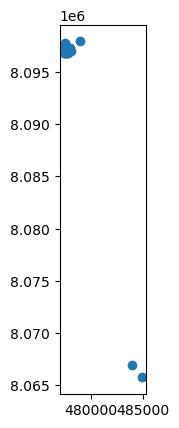

In [17]:
puntos_indi.plot()

In [18]:
# identifoca los lotes que se intersectan
gdf_lotes_cat = gpd.sjoin(gdf_cat, puntos_indi, how='inner', predicate='intersects')
# filtra los lotes intersectados en la capa original
poligonos_intersect_cat = gdf_cat.loc[gdf_cat.index.isin(gdf_lotes_cat.index)]
# copy
poligonos_intersect_cat = poligonos_intersect_cat.copy()
poligonos_intersect_cat = poligonos_intersect_cat[['unidad_01', 'unidad_02', 'unidad_03', 'unidad_04', 'unidad_05', 'area', 'soca', 'zona', 'geometry']]

In [19]:
# Cambiar el nombre de la columna 'old_name' a 'new_name'
poligonos_intersect_cat.rename(columns={'zona': 'inst'}, inplace=True)

In [20]:
poligonos_intersect_cat

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry
7597,590.0,HACIENDA PETETO,15176.0,VACA DIEZ ATALA CLAUDIO E.,L6,8.994479,0.0,50,"POLYGON ((483756.549 8067033.200, 483834.602 8..."
7600,590.0,HACIENDA PETETO,15176.0,VACA DIEZ ATALA CLAUDIO E.,L1,11.113929,0.0,50,"POLYGON ((485061.990 8065749.055, 485113.590 8..."
9797,1215.0,LA FORTUNA--SERRATE HUGO,12478.0,SERRATE COLAMARINO HUGO,L19.1,0.996967,0.0,40,"POLYGON ((477381.278 8096965.810, 477404.099 8..."
9812,1215.0,LA FORTUNA--SERRATE HUGO,12478.0,SERRATE COLAMARINO HUGO,L19.2,1.759757,0.0,40,"POLYGON ((477442.769 8097065.225, 477491.442 8..."
9900,1215.0,LA FORTUNA--SERRATE HUGO,12478.0,SERRATE COLAMARINO HUGO,L20.1,2.253572,0.0,40,"POLYGON ((477478.922 8096978.221, 477481.444 8..."
9903,1215.0,LA FORTUNA--SERRATE HUGO,12478.0,SERRATE COLAMARINO HUGO,L20.4,4.344213,0.0,40,"POLYGON ((477814.309 8096949.386, 477838.924 8..."
9913,1215.0,LA FORTUNA--SERRATE HUGO,12478.0,SERRATE COLAMARINO HUGO,L20.2,2.285379,0.0,40,"POLYGON ((477545.076 8096984.837, 477549.855 8..."
9966,1215.0,LA FORTUNA--SERRATE HUGO,12478.0,SERRATE COLAMARINO HUGO,L20.3,2.330003,0.0,40,"POLYGON ((477620.115 8096992.257, 477674.459 8..."
9988,1215.0,LA FORTUNA--SERRATE HUGO,12478.0,SERRATE COLAMARINO HUGO,L21.1,5.490818,0.0,40,"POLYGON ((477782.342 8097260.865, 477786.398 8..."
10009,1215.0,LA FORTUNA--SERRATE HUGO,12478.0,SERRATE COLAMARINO HUGO,L22,7.765456,0.0,40,"POLYGON ((478152.982 8097233.160, 478152.661 8..."


In [21]:
# CAMBIAR NOMBRE DATOS DE UNIDAD_03 Y UNDIAD_04 DE LOTES SOLICITADOS A LO INDICADO EN LOS PUNTOS
# Iterar sobre cada punto y encontrar el polígono que intersecta
for idx, point in puntos_indi.iterrows():
    point_geom = point.geometry
    matching_polygons = poligonos_intersect_cat[poligonos_intersect_cat.intersects(point_geom)]
    
    # Actualizar los campos de los polígonos que intersectan con los valores del punto
    for poly_idx in matching_polygons.index:
        poligonos_intersect_cat.at[poly_idx, 'unidad_03'] = point['unidad_03']
        poligonos_intersect_cat.at[poly_idx, 'unidad_04'] = point['unidad_04']

In [22]:
poligonos_intersect_cat.head(3)

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry
7597,590.0,HACIENDA PETETO,86.0,AGUILERA TARADELLES JOSE LUIS,L6,8.994479,0.0,50,"POLYGON ((483756.549 8067033.200, 483834.602 8..."
7600,590.0,HACIENDA PETETO,86.0,AGUILERA TARADELLES JOSE LUIS,L1,11.113929,0.0,50,"POLYGON ((485061.990 8065749.055, 485113.590 8..."
9797,1215.0,LA FORTUNA--SERRATE HUGO,12478.0,SERRATE COLAMARINO HUGO,L19.1,0.996967,0.0,40,"POLYGON ((477381.278 8096965.810, 477404.099 8..."


In [23]:
# agrega los campos faltantes
poligonos_intersect_cat['os'] = ors

In [24]:
plan = poligonos_intersect_cat.copy()

In [25]:
plan.head(3)

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry,os
7597,590.0,HACIENDA PETETO,86.0,AGUILERA TARADELLES JOSE LUIS,L6,8.994479,0.0,50,"POLYGON ((483756.549 8067033.200, 483834.602 8...",14
7600,590.0,HACIENDA PETETO,86.0,AGUILERA TARADELLES JOSE LUIS,L1,11.113929,0.0,50,"POLYGON ((485061.990 8065749.055, 485113.590 8...",14
9797,1215.0,LA FORTUNA--SERRATE HUGO,12478.0,SERRATE COLAMARINO HUGO,L19.1,0.996967,0.0,40,"POLYGON ((477381.278 8096965.810, 477404.099 8...",14


<Axes: >

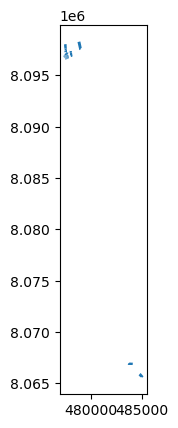

In [26]:
plan.plot()

In [27]:
plan['area'].sum()

89.40294213764419

In [28]:
#RECALCULAR EL AREA
plan['area'] = plan.geometry.area / 10000

In [29]:
plan['area'].sum()

90.90739921586206

In [30]:
# carga el shp de planificacion
gdf_plan = gpd.read_file(path_plan)

In [31]:
# determina el ultimo id
last_id = 0
if gdf_plan['id'].max() > 0:
    last_id = gdf_plan['id'].max()
else:
    last_id = 0

In [32]:
last_id

178

In [33]:
# Asignar valores incrementales a la columna 'id' empezando desde last_id + 1
plan['id'] = range(last_id + 1, last_id + 1 + len(plan))

In [34]:
plan.head(3)

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry,os,id
7597,590.0,HACIENDA PETETO,86.0,AGUILERA TARADELLES JOSE LUIS,L6,10.076988,0.0,50,"POLYGON ((483756.549 8067033.200, 483834.602 8...",14,179
7600,590.0,HACIENDA PETETO,86.0,AGUILERA TARADELLES JOSE LUIS,L1,11.113929,0.0,50,"POLYGON ((485061.990 8065749.055, 485113.590 8...",14,180
9797,1215.0,LA FORTUNA--SERRATE HUGO,12478.0,SERRATE COLAMARINO HUGO,L19.1,0.996967,0.0,40,"POLYGON ((477381.278 8096965.810, 477404.099 8...",14,181


In [35]:
len(plan)

15

In [36]:
# union de los dos gdf
gdf_pla_gral = pd.concat([gdf_plan, plan], ignore_index=True)

In [37]:
gdf_pla_gral['area'].sum()

1725.246337818049

In [38]:
gdf_pla_gral['unidad_01'] = gdf_pla_gral['unidad_01'].astype(int)
gdf_pla_gral['unidad_03'] = gdf_pla_gral['unidad_03'].astype(int)
gdf_pla_gral['os'] = gdf_pla_gral['os'].astype(int)
gdf_pla_gral['soca'] = gdf_pla_gral['soca'].astype(int)
gdf_pla_gral['id'] = gdf_pla_gral['id'].astype(int)
gdf_pla_gral['inst'] = gdf_pla_gral['inst'].astype(int)

In [39]:
gdf_pla_gral

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,os,soca,id,inst,idd,geometry
0,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L31,30.260942,1,2,1,50,1.0,"POLYGON ((504085.659 8094406.031, 503737.808 8..."
1,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L16,23.216246,1,4,2,50,1.0,"POLYGON ((504352.053 8094797.970, 504272.088 8..."
2,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,ER-L6,19.683505,1,5,3,50,1.0,"POLYGON ((503260.583 8094596.306, 503714.735 8..."
3,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L35,7.795719,1,4,4,50,1.0,"POLYGON ((504693.348 8094607.629, 504673.327 8..."
4,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L34,7.048921,1,5,5,50,1.0,"POLYGON ((504137.327 8094415.183, 504648.080 8..."
...,...,...,...,...,...,...,...,...,...,...,...,...
162,1215,LA FORTUNA--SERRATE HUGO,12478,SERRATE COLAMARINO HUGO,L23,3.545030,14,0,189,40,NaN,"POLYGON ((477947.756 8097399.025, 477951.650 8..."
163,555,LOMAS DE BIBOSI--COLAMARINO ANTONIETA,1232,AGUILERA COLAMARINO DIEGO ANDREZ,A1,20.470515,14,1,190,40,NaN,"POLYGON ((478802.877 8097745.791, 478765.453 8..."
164,1215,LA FORTUNA--SERRATE HUGO,12478,SERRATE COLAMARINO HUGO,B4,10.216212,14,5,191,40,NaN,"POLYGON ((477624.397 8098044.011, 477644.931 8..."
165,1215,LA FORTUNA--SERRATE HUGO,12478,SERRATE COLAMARINO HUGO,L2,4.949105,14,6,192,40,NaN,"POLYGON ((477438.761 8097402.153, 477441.594 8..."


In [40]:
# exportar los datos en nuevo shp
gdf_pla_gral.to_file(path_plan)

# CARGAR PLANIFICACION A AMIGOCLOUD

In [41]:
def convertir_a_multipolygon(geometry):
    if isinstance(geometry, Polygon):
        return MultiPolygon([geometry])
    return geometry

def convertir_a_wkb(polygon):
    wkb_data = wkb.dumps(polygon, hex=True)
    return wkb_data

In [42]:
# repreyectar a WGS84
gdf_pla_gral = plan.to_crs(epsg=4326)
# convertir poligonos a multipoligonos
gdf_pla_gral['geometry'] = gdf_pla_gral['geometry'].apply(convertir_a_multipolygon)

In [43]:
gdf_pla_gral['unidad_01'] = gdf_pla_gral['unidad_01'].astype(int)
gdf_pla_gral['unidad_03'] = gdf_pla_gral['unidad_03'].astype(int)
gdf_pla_gral['os'] = gdf_pla_gral['os'].astype(int)
gdf_pla_gral['soca'] = gdf_pla_gral['soca'].astype(int)
gdf_pla_gral['id'] = gdf_pla_gral['id'].astype(int)
gdf_pla_gral['inst'] = gdf_pla_gral['inst'].astype(int)

In [44]:
len(gdf_pla_gral)

15

In [45]:
# recorrer el gdf de lotes y cargarlo a amigocloud
id_proyecto = f'https://app.amigocloud.com/api/v1/projects/35248/sql'
for index, row in gdf_pla_gral.iterrows():
    wkb_hex = convertir_a_wkb(row['geometry'])
    insert_sql = f"""
    INSERT INTO dataset_360912 (id, unidad_01, unidad_02, unidad_03, unidad_04, unidad_05, area, os, geometry)
    VALUES ({row['id']}, {row['unidad_01']}, '{row['unidad_02']}', {row['unidad_03']}, '{row['unidad_04']}', '{row['unidad_05']}', {row['area']}, '{row['os']}', ST_SetSRID(ST_GeomFromWKB('\\x{wkb_hex}'), 4326));
    """
    query_sql = {'query': insert_sql}
    resultado_post = amigocloud.post(id_proyecto, query_sql)

# CARGAR XLSX

In [46]:
from openpyxl import load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from datetime import datetime

In [47]:
# Cargar el archivo Excel
sheet_name = 'DATA'
table_name = 'tbl_data'

In [48]:
excel_data = pd.read_excel(path_xlsx_parte)

In [49]:
gdf_pla_gral

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry,os,id
7597,590,HACIENDA PETETO,86,AGUILERA TARADELLES JOSE LUIS,L6,10.076988,0,50,"MULTIPOLYGON (((-63.15300 -17.48275, -63.15226...",14,179
7600,590,HACIENDA PETETO,86,AGUILERA TARADELLES JOSE LUIS,L1,11.113929,0,50,"MULTIPOLYGON (((-63.14071 -17.49436, -63.14023...",14,180
9797,1215,LA FORTUNA--SERRATE HUGO,12478,SERRATE COLAMARINO HUGO,L19.1,0.996967,0,40,"MULTIPOLYGON (((-63.21274 -17.21213, -63.21252...",14,181
9812,1215,LA FORTUNA--SERRATE HUGO,12478,SERRATE COLAMARINO HUGO,L19.2,1.759757,0,40,"MULTIPOLYGON (((-63.21216 -17.21123, -63.21170...",14,182
9900,1215,LA FORTUNA--SERRATE HUGO,12478,SERRATE COLAMARINO HUGO,L20.1,2.253572,0,40,"MULTIPOLYGON (((-63.21182 -17.21202, -63.21179...",14,183
9903,1215,LA FORTUNA--SERRATE HUGO,12478,SERRATE COLAMARINO HUGO,L20.4,4.344213,0,40,"MULTIPOLYGON (((-63.20866 -17.21228, -63.20843...",14,184
9913,1215,LA FORTUNA--SERRATE HUGO,12478,SERRATE COLAMARINO HUGO,L20.2,2.285379,0,40,"MULTIPOLYGON (((-63.21120 -17.21196, -63.21115...",14,185
9966,1215,LA FORTUNA--SERRATE HUGO,12478,SERRATE COLAMARINO HUGO,L20.3,2.330003,0,40,"MULTIPOLYGON (((-63.21049 -17.21189, -63.20998...",14,186
9988,1215,LA FORTUNA--SERRATE HUGO,12478,SERRATE COLAMARINO HUGO,L21.1,5.490818,0,40,"MULTIPOLYGON (((-63.20896 -17.20946, -63.20892...",14,187
10009,1215,LA FORTUNA--SERRATE HUGO,12478,SERRATE COLAMARINO HUGO,L22,7.765456,0,40,"MULTIPOLYGON (((-63.20548 -17.20972, -63.20548...",14,188


In [50]:
new_data = {
    'INSTITUCION':list(gdf_pla_gral['inst']), 
    'COD CANERO': list(gdf_pla_gral['unidad_03']),
    'NOMBRE CANERO': list(gdf_pla_gral['unidad_04']),
    'COD PROPIEDAD': list(gdf_pla_gral['unidad_01']),
    'NOMBRE PROPIEDAD': list(gdf_pla_gral['unidad_02']),
    'LOTE': list(gdf_pla_gral['unidad_05']),
    'HECTAREA': list(gdf_pla_gral['area']),
    'CICLO': list(gdf_pla_gral['soca']),
    'ID': list(gdf_pla_gral['id']),
    'OS': list(gdf_pla_gral['os'])
}

new_df = pd.DataFrame(new_data)

In [51]:
new_df.head(3)

,INSTITUCION,COD CANERO,NOMBRE CANERO,COD PROPIEDAD,NOMBRE PROPIEDAD,LOTE,HECTAREA,CICLO,ID,OS
0,50,86,AGUILERA TARADELLES JOSE LUIS,590,HACIENDA PETETO,L6,10.076988,0,179,14
1,50,86,AGUILERA TARADELLES JOSE LUIS,590,HACIENDA PETETO,L1,11.113929,0,180,14
2,40,12478,SERRATE COLAMARINO HUGO,1215,LA FORTUNA--SERRATE HUGO,L19.1,0.996967,0,181,14


In [52]:
# extrae los valores de Nº DE LABOR, convierte a conjunto y luego a lista
lista_cite = list(set(excel_data['Nº DE LABOR']))

In [53]:
# extrae los valores numericos de cada Nº DE LABOR
lista_num = [int(i.split('-')[-1]) for i in lista_cite]
lista_num

[2,
 18,
 14,
 20,
 11,
 6,
 27,
 21,
 26,
 5,
 13,
 17,
 1,
 25,
 15,
 22,
 19,
 9,
 10,
 4,
 8,
 12]

In [54]:
next_num_labor = max(lista_num) + 1
next_num_labor

28

In [55]:
new_df['MEZCLA'] = 0
new_df['LABOR_REALIZADA'] = 'PUL. CON DRONE'
new_df['Nº DE LABOR'] = 'PA-2025-' + str(next_num_labor)

In [56]:
new_df

,INSTITUCION,COD CANERO,NOMBRE CANERO,COD PROPIEDAD,NOMBRE PROPIEDAD,LOTE,HECTAREA,CICLO,ID,OS,MEZCLA,LABOR_REALIZADA,Nº DE LABOR
0,50,86,AGUILERA TARADELLES JOSE LUIS,590,HACIENDA PETETO,L6,10.076988,0,179,14,0,PUL. CON DRONE,PA-2025-28
1,50,86,AGUILERA TARADELLES JOSE LUIS,590,HACIENDA PETETO,L1,11.113929,0,180,14,0,PUL. CON DRONE,PA-2025-28
2,40,12478,SERRATE COLAMARINO HUGO,1215,LA FORTUNA--SERRATE HUGO,L19.1,0.996967,0,181,14,0,PUL. CON DRONE,PA-2025-28
3,40,12478,SERRATE COLAMARINO HUGO,1215,LA FORTUNA--SERRATE HUGO,L19.2,1.759757,0,182,14,0,PUL. CON DRONE,PA-2025-28
4,40,12478,SERRATE COLAMARINO HUGO,1215,LA FORTUNA--SERRATE HUGO,L20.1,2.253572,0,183,14,0,PUL. CON DRONE,PA-2025-28
5,40,12478,SERRATE COLAMARINO HUGO,1215,LA FORTUNA--SERRATE HUGO,L20.4,4.344213,0,184,14,0,PUL. CON DRONE,PA-2025-28
6,40,12478,SERRATE COLAMARINO HUGO,1215,LA FORTUNA--SERRATE HUGO,L20.2,2.285379,0,185,14,0,PUL. CON DRONE,PA-2025-28
7,40,12478,SERRATE COLAMARINO HUGO,1215,LA FORTUNA--SERRATE HUGO,L20.3,2.330003,0,186,14,0,PUL. CON DRONE,PA-2025-28
8,40,12478,SERRATE COLAMARINO HUGO,1215,LA FORTUNA--SERRATE HUGO,L21.1,5.490818,0,187,14,0,PUL. CON DRONE,PA-2025-28
9,40,12478,SERRATE COLAMARINO HUGO,1215,LA FORTUNA--SERRATE HUGO,L22,7.765456,0,188,14,0,PUL. CON DRONE,PA-2025-28


In [57]:
final_data = pd.concat([excel_data, new_df], ignore_index=True)

In [58]:
final_data.to_excel(path_xlsx_parte, index=False)